# Ryzen AI CVML Library

The Ryzen AI Computer Vision and Machine Learning (CVML) library provides optimized, ready-to-use computer vision features that can run on multiple hardware backends. In this notebook we'll explore depth estimation across different accelerators and measure their power efficiency.

## Goals

* Learn about the Ryzen AI CVML library
* Run depth estimation on NPU, CPU, and GPU
* Compare power consumption and performance
* Understand hardware tradeoffs for edge AI

## References

* [Ryzen AI CVML Library](https://ryzenai.docs.amd.com/en/latest/ryzen_ai_libraries.html)
* [Depth Anything V2 Paper](https://arxiv.org/abs/2406.09414)
* [RyzenAI GitHub](https://github.com/amd/RyzenAI-SW)

## What is CVML?

The Ryzen AI CVML library abstracts the complexity of running optimized computer vision models across different hardware. It provides:

- **Ready-to-use CV features**: Depth estimation, face detection, face mesh, and more
- **Hardware abstraction**: Same C++ API works across NPU, GPU, and CPU backends  
- **Optimized models**: Pre-quantized INT8 models for NPU, leveraging Depth Anything V2 architecture
- **Low power operation**: NPU provides hardware acceleration with minimal power draw

For this workshop we'll focus on **depth estimation** - estimating the distance of objects from a camera using only RGB images.

## Building CVML Samples

We've created CVML samples with prebuilt NPU and CPU backend binaries. These are minimal modifications of the official samples - differing only in the backend selection line. Let's build them:

In [1]:
!cd cvml_samples && ./build.sh

Building CVML samples...
Running CMake...
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.6.0") 
-- Found RyzenAILibrary: /ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-depth-estimation.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-face-detector.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-facemesh.so;/ryzers/notebooks/Ryzen-AI-CVML-Library/linux/libcvml-sdk.so  
-- Configuring done (0.2s)
-- Generating done (0.0s)
-- Build files have been written to: /ryzers/notebooks

## Environment Setup

Since we're running in a headless environment without a display, we need to configure Qt to use offscreen rendering. This prevents the samples from trying to open GUI windows.

In [2]:
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
print("Qt configured for headless mode")

Qt configured for headless mode


## Step 1: Depth Estimation on a Single Image

Let's start simple - extract a single frame from the sample video and run depth estimation on it. This gives us immediate visual feedback on what depth estimation does.

### Extract a Test Frame

Extracted frame: 1920x1080 pixels


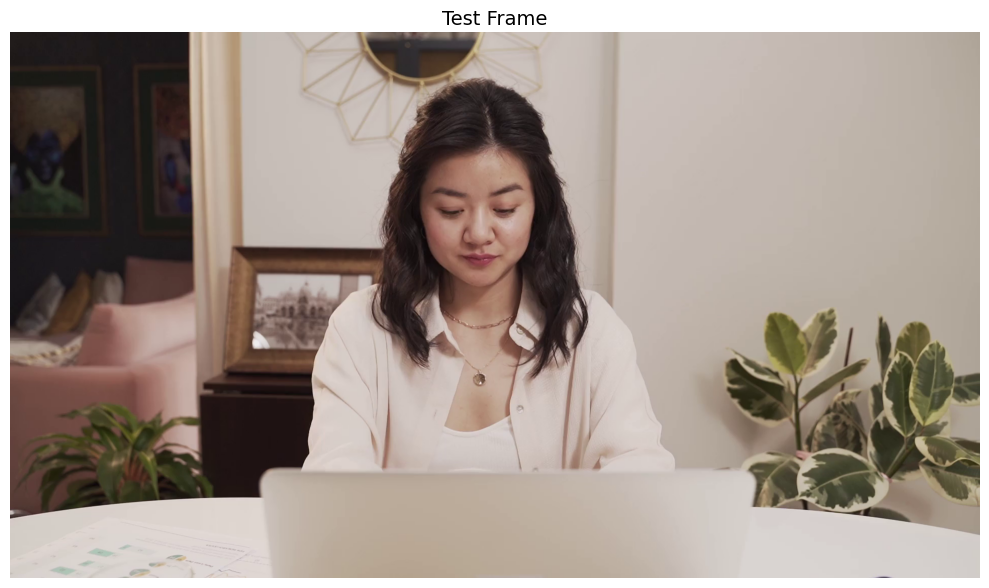

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Extract first frame from video
video_path = 'Ryzen-AI-CVML-Library/samples/video_call.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

cv2.imwrite('test_frame.jpg', frame)
print(f"Extracted frame: {frame.shape[1]}x{frame.shape[0]} pixels")

# Display it
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Test Frame', fontsize=14)
plt.tight_layout()
plt.show()

### Run NPU Depth Estimation

Now let's process this frame using the NPU. The CVML library uses Depth Anything V2 models quantized to INT8 for efficient NPU execution.

In [4]:
!./build/depth_estimation_npu -i test_frame.jpg -o depth_npu.jpg

[INFO] time:120150614 thread:128280759901568 AMD CVML SDK: 0.0.0-dev
[INFO] time:120150614 thread:128280759901568 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
Using NPU backend
[INFO] time:120150621 thread:128280759901568 [Depth Estimation] Using ONNX engine, NPU backend
Image file read: test_frame.jpg
I20251014 06:28:30.292805  3660 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251014 06:28:30.292860  3660 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251014 06:28:30.292867  3660 vitisai_compile_model.cpp:1148] 	 efficient_Unet::input_0_nhwc : [1x256x256x3]
I20251014 06:28:30.292871  3660 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (1)
I20251014 06:28:30.292874  3660 vitisai_compile_model.cpp:1158] 	 2196_nhwc : [1x256x256x1]
[Vitis AI EP] No. of Operators :   CPU     2    NPU   616 
[Vitis AI EP] No. of Subgraphs :   NPU     1 Actually running on NPU     1 
[INFO] time:120151107 thread:128280489297600 

### Visualize the Result

Depth maps use color to represent distance - warmer colors (red/yellow) indicate closer objects, while cooler colors (blue/green) indicate objects farther away.

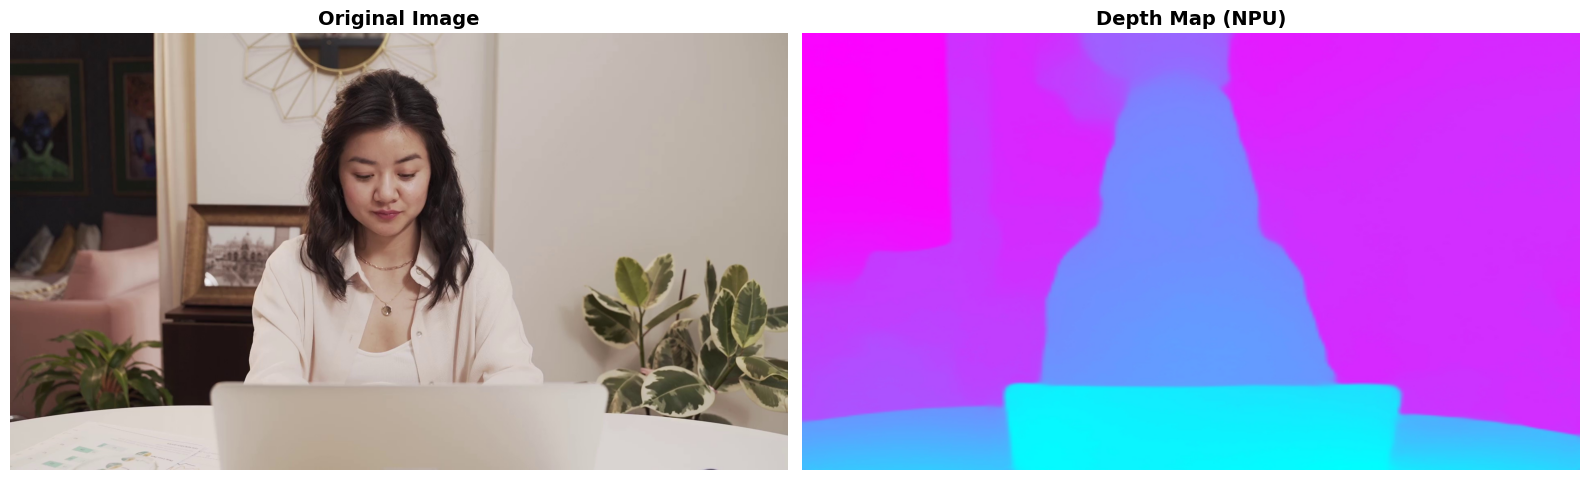

In [5]:
# Load and display side-by-side comparison
original = cv2.imread('test_frame.jpg')
depth = cv2.imread('depth_npu.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(depth, cv2.COLOR_BGR2RGB))
ax2.set_title('Depth Map (NPU)', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('depth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 2: Video Processing with Power Monitoring

Now let's process the full video across different backends and monitor power consumption. This demonstrates the key advantage of the NPU - **power efficiency**.

We'll measure power using `rocm-smi` which reports socket-level power consumption. While this includes the entire APU (CPU + GPU + NPU), we can still observe relative differences between workloads.

### Power Monitoring Setup

First, let's set up our power monitoring infrastructure. We'll sample power every 500ms while the workload runs.

In [10]:
import subprocess
import threading
import time
import re

def monitor_power(power_samples, monitoring_flag):
    """Monitor power consumption using rocm-smi."""
    while monitoring_flag['active']:
        try:
            result = subprocess.run(
                ['rocm-smi', '--showpower'],
                capture_output=True,
                text=True,
                timeout=2
            )
            # Parse power from output
            match = re.search(r'Power \(W\): (\d+\.\d+)', result.stdout)
            if match:
                power_samples.append(float(match.group(1)))
        except:
            pass
        time.sleep(0.5)  # Sample every 500ms

def run_inference_with_power(backend='npu'):
    """Run depth estimation and measure power consumption."""
    power_samples = []
    monitoring_flag = {'active': True}
    
    # Start power monitoring
    monitor_thread = threading.Thread(
        target=monitor_power, 
        args=(power_samples, monitoring_flag),
        daemon=True
    )
    monitor_thread.start()
    
    # Prepare command
    if backend == 'npu':
        cmd = ['./build/depth_estimation_npu',
               '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
               '-o', 'output_npu.mp4']
    elif backend == 'cpu':
        cmd = ['./build/depth_estimation_cpu',
               '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4', 
               '-o', 'output_cpu.mp4']
    else:  # gpu
        cmd = ['python3', 'depth_estimation_gpu_midas.py',
               '-i', 'Ryzen-AI-CVML-Library/samples/video_call.mp4',
               '-o', 'output_gpu.mp4']
    
    # Run inference
    start = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True)
    duration = time.time() - start
    
    # Stop monitoring
    monitoring_flag['active'] = False
    monitor_thread.join(timeout=2)
    
    return duration, power_samples, result

### NPU Video Processing

Let's run depth estimation on the NPU and measure its power consumption.

In [11]:
print("Starting NPU depth estimation with power monitoring...\n")
npu_duration, npu_power_samples, npu_result = run_inference_with_power('npu')

# Calculate statistics
npu_avg_power = np.mean(npu_power_samples)
npu_max_power = np.max(npu_power_samples)
npu_min_power = np.min(npu_power_samples)

print(f"  Duration: {npu_duration:.2f}s")
print(f"  Average Power: {npu_avg_power:.2f}W")
print(f"  Peak Power: {npu_max_power:.2f}W")
print(f"  Min Power: {npu_min_power:.2f}W")
print(f"  Total Energy: {(npu_avg_power * npu_duration):.2f}J")

npu_stats = {
    'duration': npu_duration,
    'avg_power': npu_avg_power,
    'samples': npu_power_samples
}

Starting NPU depth estimation with power monitoring...

  Duration: 15.98s
  Average Power: 28.08W
  Peak Power: 30.05W
  Min Power: 17.06W
  Total Energy: 448.67J


### CPU Video Processing

Now let's run the same workload on the CPU using ONNX Runtime. Note that the CPU backend in CVML actually falls back to ONNX Runtime's CPU execution provider when we request the GPU backend.

In [12]:
print("Starting CPU depth estimation with power monitoring...\n")
cpu_duration, cpu_power_samples, cpu_result = run_inference_with_power('cpu')

# Calculate statistics
cpu_avg_power = np.mean(cpu_power_samples)
cpu_max_power = np.max(cpu_power_samples)

print(f"  Duration: {cpu_duration:.2f}s")
print(f"  Average Power: {cpu_avg_power:.2f}W")
print(f"  Peak Power: {cpu_max_power:.2f}W")
print(f"  Total Energy: {(cpu_avg_power * cpu_duration):.2f}J")

cpu_stats = {
    'duration': cpu_duration,
    'avg_power': cpu_avg_power,
    'samples': cpu_power_samples
}

Starting CPU depth estimation with power monitoring...

  Duration: 22.69s
  Average Power: 91.07W
  Peak Power: 97.05W
  Total Energy: 2066.39J


### GPU Video Processing

Finally, let's run on the GPU using PyTorch with MiDaS - a well established small depth estimation model that should run comparatively fast on the iGPU.

In [13]:
print("Starting GPU depth estimation with power monitoring...\n")
gpu_duration, gpu_power_samples, gpu_result = run_inference_with_power('gpu')

# Calculate statistics  
gpu_avg_power = np.mean(gpu_power_samples)
gpu_max_power = np.max(gpu_power_samples)

print(f"  Duration: {gpu_duration:.2f}s")
print(f"  Average Power: {gpu_avg_power:.2f}W")
print(f"  Peak Power: {gpu_max_power:.2f}W")
print(f"  Total Energy: {(gpu_avg_power * gpu_duration):.2f}J")

gpu_stats = {
    'duration': gpu_duration,
    'avg_power': gpu_avg_power,
    'samples': gpu_power_samples
}

Starting GPU depth estimation with power monitoring...

  Duration: 14.63s
  Average Power: 47.74W
  Peak Power: 91.00W
  Total Energy: 698.38J


## Performance & Power Comparison

Now let's visualize the results to understand the tradeoffs between NPU, CPU, and GPU execution.

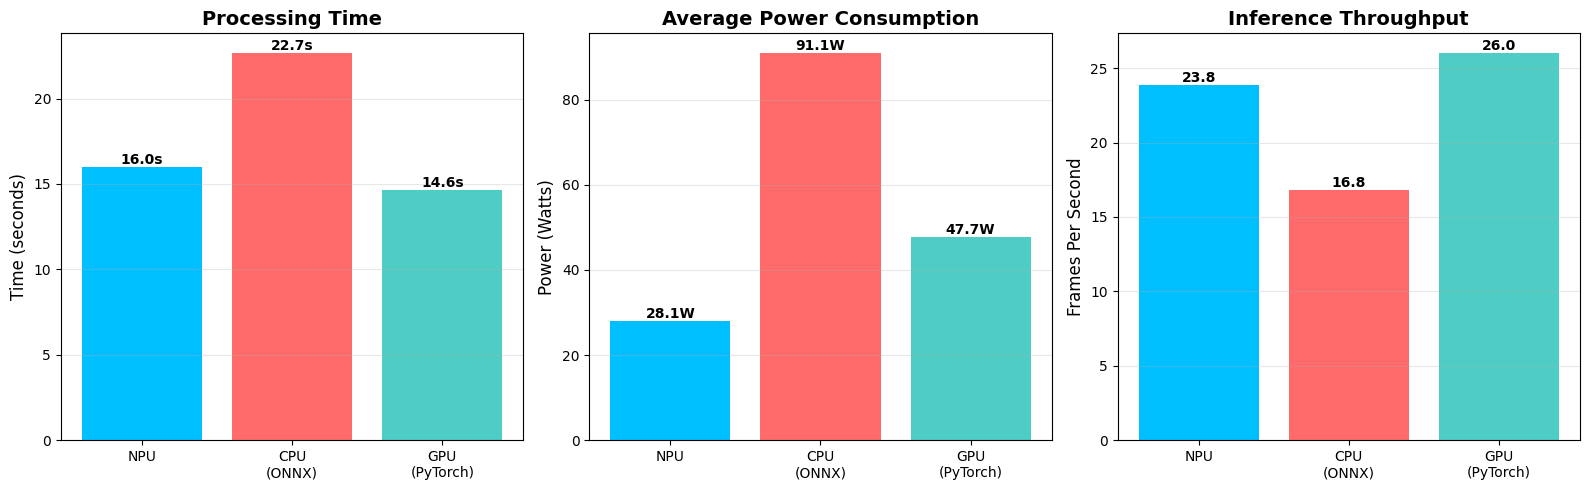


PERFORMANCE SUMMARY

Video: 381 frames

NPU (CVML INT8):
  ├─ Time: 15.98s
  ├─ FPS: 23.8
  ├─ Avg Power: 28.08W
  └─ Energy: 448.67J

CPU (ONNX Runtime):
  ├─ Time: 22.69s
  ├─ FPS: 16.8
  ├─ Avg Power: 91.07W
  └─ Energy: 2066.39J

GPU (PyTorch INT8):
  ├─ Time: 14.63s
  ├─ FPS: 26.0
  ├─ Avg Power: 47.74W
  └─ Energy: 698.38J

Energy Efficiency (frames/joule):
  ├─ NPU: 0.849
  ├─ CPU: 0.184
  └─ GPU: 0.546


In [15]:
# Get video info for FPS calculation
cap = cv2.VideoCapture('Ryzen-AI-CVML-Library/samples/video_call.mp4')
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Calculate FPS
npu_fps = frame_count / npu_stats['duration'] if npu_stats['duration'] > 0 else 0
cpu_fps = frame_count / cpu_stats['duration'] if cpu_stats['duration'] > 0 else 0
gpu_fps = frame_count / gpu_stats['duration'] if gpu_stats['duration'] > 0 else 0

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

backends = ['NPU', 'CPU\n(ONNX)', 'GPU\n(PyTorch)']
colors = ['#00BFFF', '#FF6B6B', '#4ECDC4']

# 1. Processing Time
durations = [npu_stats['duration'], cpu_stats['duration'], gpu_stats['duration']]
axes[0].bar(backends, durations, color=colors)
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Processing Time', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(durations):
    axes[0].text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')

# 2. Average Power
powers = [npu_stats['avg_power'], cpu_stats['avg_power'], gpu_stats['avg_power']]
axes[1].bar(backends, powers, color=colors)
axes[1].set_ylabel('Power (Watts)', fontsize=12)
axes[1].set_title('Average Power Consumption', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(powers):
    axes[1].text(i, v, f'{v:.1f}W', ha='center', va='bottom', fontweight='bold')

# 3. Throughput (FPS)
fps_values = [npu_fps, cpu_fps, gpu_fps]
axes[2].bar(backends, fps_values, color=colors)
axes[2].set_ylabel('Frames Per Second', fontsize=12)
axes[2].set_title('Inference Throughput', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(fps_values):
    axes[2].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('backend_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"\nVideo: {frame_count} frames")
print(f"\nNPU (CVML INT8):")
print(f"  ├─ Time: {npu_stats['duration']:.2f}s")
print(f"  ├─ FPS: {npu_fps:.1f}")
print(f"  ├─ Avg Power: {npu_stats['avg_power']:.2f}W")
print(f"  └─ Energy: {(npu_stats['avg_power'] * npu_stats['duration']):.2f}J")
print(f"\nCPU (ONNX Runtime):")
print(f"  ├─ Time: {cpu_stats['duration']:.2f}s")
print(f"  ├─ FPS: {cpu_fps:.1f}")
print(f"  ├─ Avg Power: {cpu_stats['avg_power']:.2f}W")
print(f"  └─ Energy: {(cpu_stats['avg_power'] * cpu_stats['duration']):.2f}J")
print(f"\nGPU (PyTorch INT8):")
print(f"  ├─ Time: {gpu_stats['duration']:.2f}s")
print(f"  ├─ FPS: {gpu_fps:.1f}")
print(f"  ├─ Avg Power: {gpu_stats['avg_power']:.2f}W")
print(f"  └─ Energy: {(gpu_stats['avg_power'] * gpu_stats['duration']):.2f}J")

# Calculate efficiency metric (frames per joule)
npu_efficiency = frame_count / (npu_stats['avg_power'] * npu_stats['duration']) if npu_stats['avg_power'] > 0 else 0
cpu_efficiency = frame_count / (cpu_stats['avg_power'] * cpu_stats['duration']) if cpu_stats['avg_power'] > 0 else 0
gpu_efficiency = frame_count / (gpu_stats['avg_power'] * gpu_stats['duration']) if gpu_stats['avg_power'] > 0 else 0

print(f"\nEnergy Efficiency (frames/joule):")
print(f"  ├─ NPU: {npu_efficiency:.3f}")
print(f"  ├─ CPU: {cpu_efficiency:.3f}")
print(f"  └─ GPU: {gpu_efficiency:.3f}")

### Power Consumption Timeline

Let's plot the power consumption over time for each backend to see how they behave during inference.

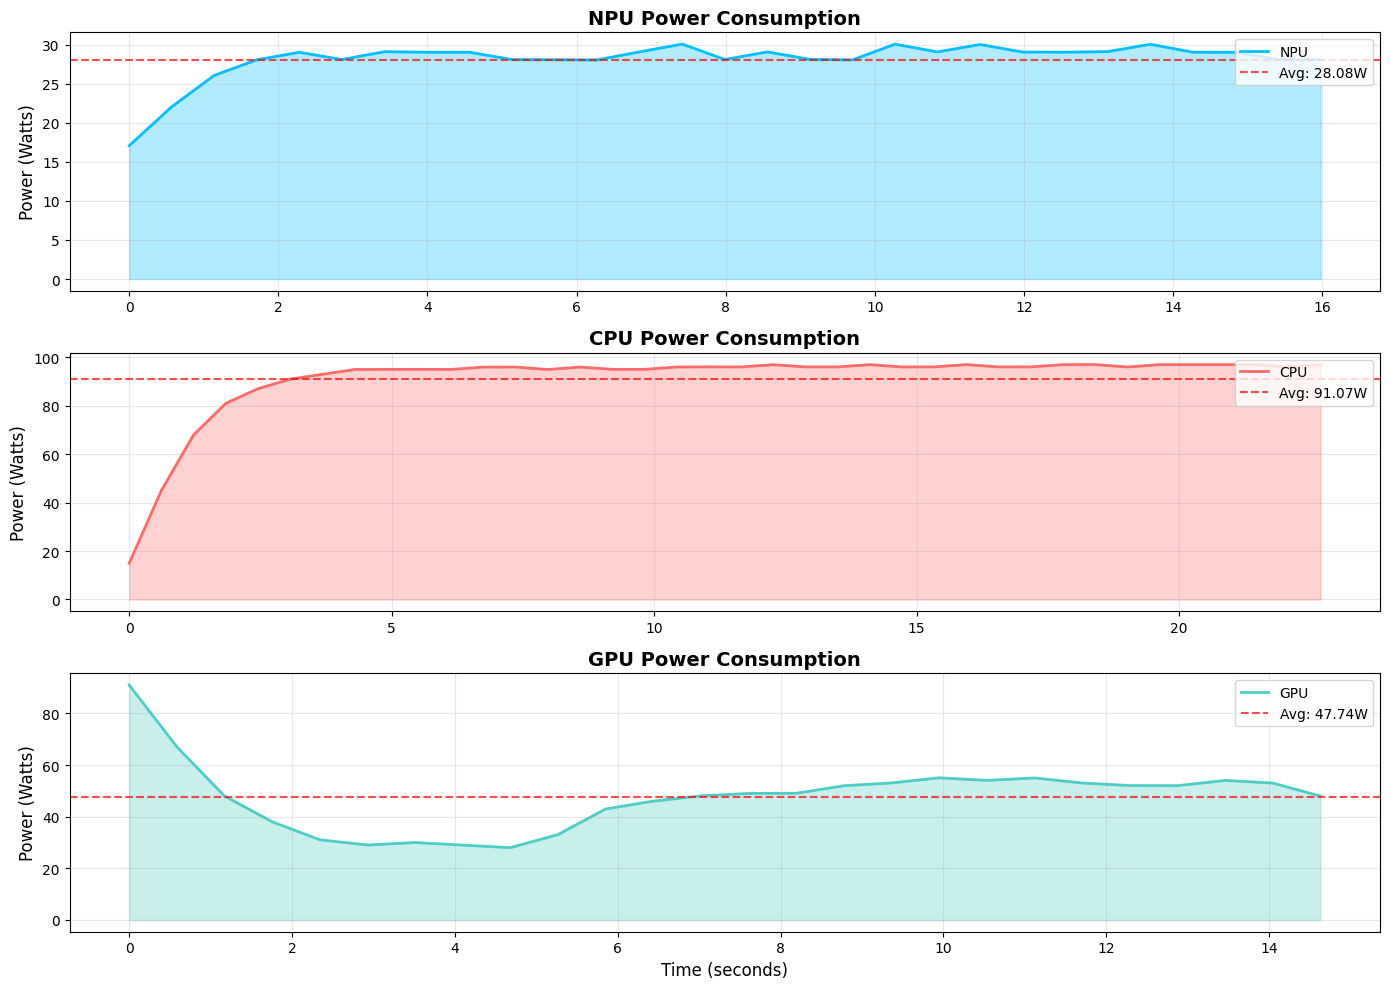

In [16]:
# Plot power consumption over time for all backends
if npu_stats['samples'] and cpu_stats['samples'] and gpu_stats['samples']:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
    
    # NPU power timeline
    npu_time = np.linspace(0, npu_stats['duration'], len(npu_stats['samples']))
    ax1.plot(npu_time, npu_stats['samples'], color='#00BFFF', linewidth=2, label='NPU')
    ax1.axhline(npu_stats['avg_power'], color='red', linestyle='--', alpha=0.7, 
                label=f'Avg: {npu_stats["avg_power"]:.2f}W')
    ax1.fill_between(npu_time, npu_stats['samples'], alpha=0.3, color='#00BFFF')
    ax1.set_ylabel('Power (Watts)', fontsize=12)
    ax1.set_title('NPU Power Consumption', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)
    
    # CPU power timeline
    cpu_time = np.linspace(0, cpu_stats['duration'], len(cpu_stats['samples']))
    ax2.plot(cpu_time, cpu_stats['samples'], color='#FF6B6B', linewidth=2, label='CPU')
    ax2.axhline(cpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7,
                label=f'Avg: {cpu_stats["avg_power"]:.2f}W')
    ax2.fill_between(cpu_time, cpu_stats['samples'], alpha=0.3, color='#FF6B6B')
    ax2.set_ylabel('Power (Watts)', fontsize=12)
    ax2.set_title('CPU Power Consumption', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    # GPU power timeline
    gpu_time = np.linspace(0, gpu_stats['duration'], len(gpu_stats['samples']))
    ax3.plot(gpu_time, gpu_stats['samples'], color='#4ECDC4', linewidth=2, label='GPU')
    ax3.axhline(gpu_stats['avg_power'], color='red', linestyle='--', alpha=0.7,
                label=f'Avg: {gpu_stats["avg_power"]:.2f}W')
    ax3.fill_between(gpu_time, gpu_stats['samples'], alpha=0.3, color='#4ECDC4')
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.set_ylabel('Power (Watts)', fontsize=12)
    ax3.set_title('GPU Power Consumption', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('power_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Power timeline not available (insufficient samples)")

## What to try next

* Try running other features like face detection and face mesh
* Check out the `depth_estimation_gpu_midas.py` script and try other sizes - the one we ran was the smallest.

Example running face detection:

Running with fast Retinaface model
[INFO] time:120541074 thread:125130533621120 AMD CVML SDK: 0.0.0-dev
[INFO] time:120541074 thread:125130533621120 Any GPU inference will use AMD Radeon Graphics (RADV GFX1151)[0]
[INFO] time:120541087 thread:125130533621120 [Face Detector] Using ONNX engine, NPU backend
I20251014 06:35:00.732635  4854 vitisai_compile_model.cpp:1143] Vitis AI EP Load ONNX Model Success
I20251014 06:35:00.732672  4854 vitisai_compile_model.cpp:1144] Graph Input Node Name/Shape (1)
I20251014 06:35:00.732679  4854 vitisai_compile_model.cpp:1148] 	 RetinaFace::input_0 : [1x3x188x320]
I20251014 06:35:00.732683  4854 vitisai_compile_model.cpp:1154] Graph Output Node Name/Shape (3)
I20251014 06:35:00.732686  4854 vitisai_compile_model.cpp:1158] 	 1216 : [1x2820x4]
I20251014 06:35:00.732689  4854 vitisai_compile_model.cpp:1158] 	 1302 : [1x2820x3]
I20251014 06:35:00.732692  4854 vitisai_compile_model.cpp:1158] 	 1388 : [1x2820x10]
[Vitis AI EP] No. of Operators :   CPU     4  

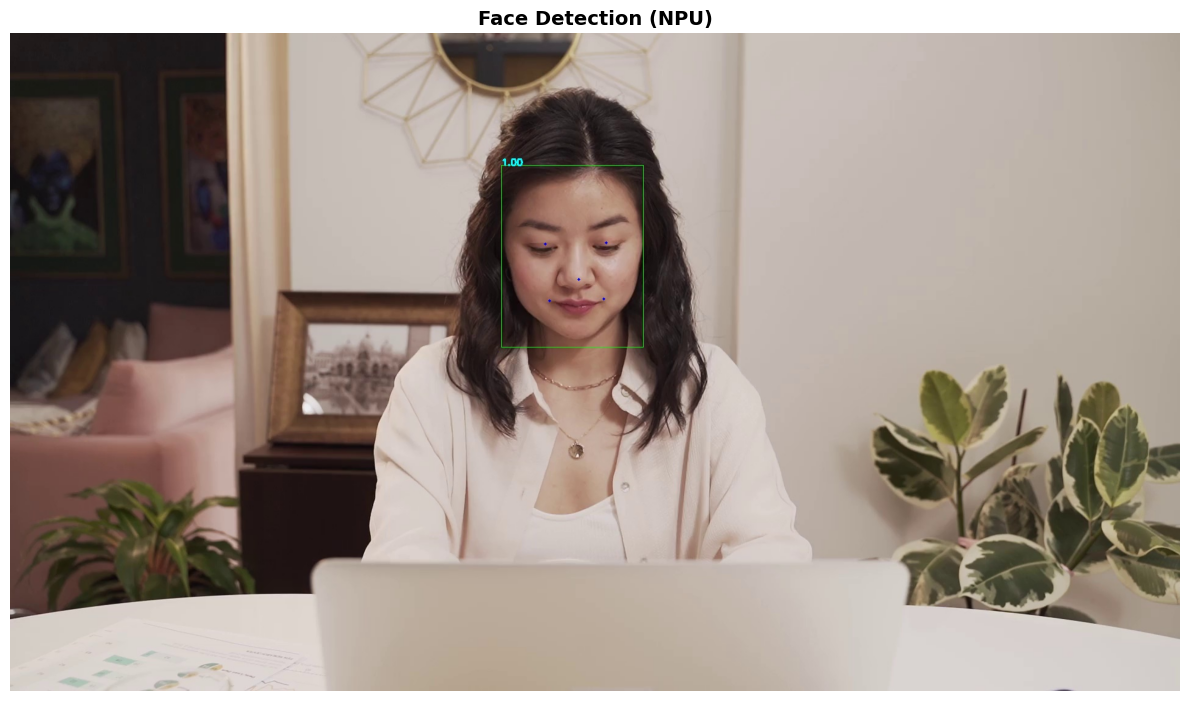


✓ Face detection complete!
  Green boxes: detected faces
  Red dots: facial landmarks
  Yellow text: confidence scores


In [17]:
# Run face detection on single image
!./build/face_detection_npu -i test_frame.jpg -m fast -o face_npu.jpg

# Display result
face_result = cv2.imread('face_npu.jpg')
if face_result is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(face_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Face Detection (NPU)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Face detection complete!")
    print("  Green boxes: detected faces")
    print("  Red dots: facial landmarks")
    print("  Yellow text: confidence scores")
else:
    print("Could not load face detection result")

## Key Takeaways

### When to Use Each Backend

- **NPU**: Best for always-on, power-constrained applications (robotics, edge devices, battery-powered systems)
- **GPU**: Best for maximum throughput, batch processing, or when GPU is already active for other tasks
- **CPU**: Fallback option for maximum compatibility, or when dedicated accelerators unavailable

### Typical Performance Characteristics

Based on your measurements above, you should observe:

- **NPU**: Moderate throughput (20-40 FPS), lowest power consumption (5-15W)
- **CPU**: Lower throughput (10-20 FPS), moderate power consumption (15-25W)  
- **GPU**: Highest throughput (40-80 FPS), highest power consumption (20-40W)

The NPU typically achieves **2-4x better energy efficiency** (frames per joule) compared to GPU, making it ideal for edge AI applications where power is a primary constraint.

*Note: Actual values depend on your hardware configuration and workload characteristics*

## Next Steps

Now that you understand how to use CVML and compare backends, in the next notebook we'll integrate these vision features into ROS 2 for building real robotic applications.

**Continue to**: [3_cvml_ros.ipynb](3_cvml_ros.ipynb)

## Cleanup (Optional)

Remove generated output files to save space:

In [ ]:
!rm -f output_*.mp4 test_frame.jpg depth_*.jpg face_*.jpg *.png
print("✓ Cleanup complete!")

---
Copyright© 2025 AMD, Inc. SPDX-License-Identifier: MIT